# Covid-19 Case Prediction in Malaysia  
## Introduction  

### Objective  
The objective of this project is to **predict next week’s daily Covid-19 cases in Malaysia** using supervised learning models.  

This regression problem will be approached using **three supervised learning methods**:  
1. Linear Regression  
2. K-Nearest Neighbors (KNN) Regressor  
3. Decision Tree Regressor  

### Motivation  
- Predicting Covid-19 cases 7 days ahead helps governments and healthcare authorities prepare for surges.  
- Accurate predictions can inform **hospital readiness, vaccination campaigns, and policy interventions**.  
- By comparing different machine learning models, we aim to evaluate which method balances **prediction accuracy and computational efficiency**.  

### Dataset  
Source: [Ministry of Health Malaysia (MoH) GitHub Repository](https://github.com/MoH-Malaysia/covid19-public)  

We will use **country-level daily data**:  
- Daily new cases  
- Testing numbers  
- Hospital & ICU utilization  
- Vaccination progress  

We will use a **6-month consecutive date range**, starting from `START_DATE` (e.g., March 1, 2022).  
- End date will be computed automatically as **6 months after start**.  
- This ensures enough samples for training and testing while remaining focused on a meaningful period.  

### Methodology Overview  
The notebook will follow these steps:  
1. **Data Collection & Cleaning** – Load datasets and preprocess  
2. **Feature Engineering** – Transform and scale features for modeling  
3. **Dataset Splitting** – Train, validation, and test sets  
4. **Model Training** – Train Linear Regression, KNN Regressor, and Decision Tree Regressor  
5. **Plotting & Evaluation** – Metrics and visualization: predicted vs actual, residuals, error curves  
6. **Analysis & Conclusion** – Compare model performance and summarize findings  

### Hyperparameters to Tune
1. **Linear Regression**: `fit_intercept`, `normalize`, regularization (`Ridge` / `Lasso` with `alpha`)  
2. **KNN Regressor**: `n_neighbors`, `weights`, `metric`, `leaf_size`  
3. **Decision Tree Regressor**: `max_depth`, `min_samples_split`, `min_samples_leaf`, `max_features`, `criterion`  

### Evaluation Metrics
1. Mean Absolute Error (MAE)  
2. Mean Squared Error (MSE) / Root MSE (RMSE)  
3. R² Score  
4. Training speed  

### Visualization
1. Predicted vs Actual scatter plot  
2. Residual plots  
3. Train vs Validation error curves


In [165]:
# --- Import libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time

# --- Set constants ---
START_DATE = pd.to_datetime("2022-03-01")
END_DATE = START_DATE + pd.DateOffset(months=6) - pd.Timedelta(days=1)


# Part 1: Data Collection & Cleaning

### Data Source
We will use official Malaysian Covid-19 datasets provided by the **Ministry of Health Malaysia (MoH)**, available on GitHub:  
[https://github.com/MoH-Malaysia/covid19-public](https://github.com/MoH-Malaysia/covid19-public)

### Selected Files
For this project, we will mainly use:
1. `cases_malaysia.csv` → Daily Covid-19 cases (our primary target variable)  
2. `tests_malaysia.csv` → Daily testing numbers  
3. `hospital.csv` → Hospitalization data  
4. `icu.csv` → ICU utilization data  
5. `vax_malaysia.csv` → Vaccination progress  

### Target Variable
- Our target variable for regression is `cases_new`, i.e., the **number of new Covid-19 cases per day**.


In [166]:
# --- Read the CSV files ---
datasets = {
    "cases": pd.read_csv("cases_malaysia.csv"),
    "tests": pd.read_csv("tests_malaysia.csv"),
    "hospital": pd.read_csv("hospital.csv"),
    "icu": pd.read_csv("icu.csv"),
    "vax": pd.read_csv("vax_malaysia.csv"),
}

# --- Data Cleaning ---
for name, df in datasets.items():
    # Convert date column to datetime
    df["date"] = pd.to_datetime(df["date"])
    
    # Filter to 6-month range
    df = df[(df["date"] >= START_DATE) & (df["date"] <= END_DATE)].copy()
    
    # Drop empty cluster columns in cases dataset
    if name == "cases":
        cluster_cols = [
            "cluster_import", "cluster_religious", "cluster_community",
            "cluster_highRisk", "cluster_education", "cluster_detectionCentre",
            "cluster_workspace"
        ]
        df.drop(columns=cluster_cols, inplace=True, errors="ignore")
    
    # Aggregate numeric columns by date
    df = df.groupby("date").sum(numeric_only=True).reset_index()
    
    # Drop columns with a single unique value
    nunique = df.nunique()
    cols_to_drop = nunique[nunique <= 1].index
    df.drop(columns=cols_to_drop, inplace=True, errors="ignore")
    
    # Fill missing values with 0
    df.fillna(0, inplace=True)
    
    # Save cleaned dataset
    datasets[name] = df

# --- Merge all datasets on date ---
from functools import reduce
df = reduce(lambda left, right: pd.merge(left, right, on="date", how="left"), datasets.values())

# --- Sort by date ---
df = df.sort_values("date").reset_index(drop=True)

# --- Display cleaned dataset ---
df


,date,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_unvax,cases_pvax,cases_fvax,cases_boost,...,sinopharm2,sinopharm3,sinopharm4,cansino,cansino3,cansino4,pending1,pending2,pending3,pending4
0,2022-03-01,25854,448,25548,293658,484,4055,372,9417,12010,...,15,19,0,33,34,1,3,0,3,1
1,2022-03-02,27500,428,27557,293486,362,4392,484,9699,12925,...,12,4,0,54,15,0,0,0,17,0
2,2022-03-03,32467,413,27629,298238,472,4966,579,11486,15436,...,10,13,0,49,12,0,0,0,18,1
3,2022-03-04,33209,441,26352,305017,472,5160,615,10959,16475,...,6,61,0,74,12,0,6,0,1,0
4,2022-03-05,33406,342,27143,311213,394,4897,617,10842,17050,...,8,242,1,158,16,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,2022-08-27,2491,0,3715,34515,1,240,8,533,1710,...,1,0,0,0,0,0,0,0,0,0
180,2022-08-28,2191,1,3796,32908,3,220,10,432,1529,...,0,0,0,0,0,0,0,0,0,0
181,2022-08-29,1946,1,3271,31575,20,247,8,399,1292,...,2,3,1,0,0,0,0,0,0,0
182,2022-08-30,2144,3,2549,31166,8,204,12,480,1448,...,1,0,0,0,0,0,0,0,1,0


# Part 2: Feature Engineering

We organize feature engineering into three subparts:

1. **Feature Selection** – select relevant numerical metrics and drop redundant or noisy columns.  
2. **Feature Transformation** – scale features and handle skewed distributions to improve model performance.  
3. **Feature Creation (Lagging)** – create lag features from the past 7–14 days to predict next week's cases.

### Part 2.1: Feature Selection

**Objective:** Reduce noise and prevent overfitting by selecting relevant numerical features.

**Reasoning:**
- Drop highly detailed or redundant columns that are unlikely to improve prediction accuracy:
  - **Case breakdowns** by age or vaccination type (correlated with total cases)
  - **ICU/ventilator subcategories** (aggregated in broader metrics)
  - **Vaccination subgroups** (aggregated)
  - **Date column** to avoid leakage
- This ensures the model focuses on metrics most predictive of next week’s Covid-19 cases.

In [167]:
# --- Feature Selection ---

features_to_drop = [
    # Date
    'date',
    
    # Cases breakdowns
    'cases_import', 'cases_recovered', 'cases_cluster', 'cases_pvax', 'cases_fvax',
    'cases_child', 'cases_adolescent', 'cases_adult', 'cases_elderly',
    'cases_0_4', 'cases_5_11', 'cases_12_17', 'cases_18_29', 'cases_30_39',
    'cases_40_49', 'cases_50_59', 'cases_60_69', 'cases_70_79', 'cases_80',
    
    # Hospital / ICU subcategories
    'admitted_pui', 'admitted_covid', 'admitted_total', 'discharged_pui', 'discharged_covid', 
    'discharged_total', 'hosp_covid', 'hosp_pui', 'hosp_noncovid', 'beds_icu_rep', 
    'beds_icu_total', 'beds_icu_covid', 'icu_pui', 'icu_noncovid', 'vent_covid', 
    'vent_pui', 'vent_noncovid', 'vent_used', 'vent_port_used',
    
    # Vaccination subgroups
    'daily_partial_adol', 'daily_full_adol', 'daily_partial_child', 'daily_full_child',
    'cumul_partial_adol', 'cumul_full_adol', 'cumul_partial_child', 'cumul_full_child',
    'pfizer1', 'pfizer2', 'pfizer3', 'sinovac1', 'sinovac2', 'sinovac3', 'astra1', 
    'astra2', 'sinopharm1', 'sinopharm2', 'cansino', 'pending1', 'pending2', 'pending3'
]

# Select relevant features
features = df.drop(columns=features_to_drop, errors="ignore")
print("Selected features for modeling:", features.columns.tolist())


Selected features for modeling: ['cases_new', 'cases_active', 'cases_unvax', 'cases_boost', 'rtk-ag', 'pcr', 'beds', 'beds_covid', 'beds_noncrit', 'beds_icu', 'vent', 'vent_port', 'icu_covid', 'daily_partial', 'daily_full', 'daily_booster', 'daily_booster2', 'daily', 'daily_booster_adol', 'daily_booster2_adol', 'daily_booster_child', 'daily_booster2_child', 'cumul_partial', 'cumul_full', 'cumul_booster', 'cumul_booster2', 'cumul', 'cumul_booster_adol', 'cumul_booster2_adol', 'cumul_booster_child', 'cumul_booster2_child', 'pfizer4', 'sinovac4', 'astra3', 'astra4', 'sinopharm3', 'sinopharm4', 'cansino3', 'cansino4', 'pending4']


### Part 2.2: Feature Transformation

**Objective:** Transform features to improve model performance by:

1. **Scaling:** Using `StandardScaler` so features are comparable for distance-based methods (KNN) and regression optimization.
2. **Handling skewed distributions:** Apply log transformation to reduce the effect of extreme values.

**Reasoning:**  
- Without scaling, features with large ranges dominate KNN distance calculations and regression weight updates.  
- Skewed features can bias the model toward outliers. Log transformation stabilizes learning and improves convergence.


In [168]:
# --- Log-transform to reduce skewness ---
log_transformer = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)
X_log = log_transformer.fit_transform(features)  # fit_transform to compute on dataset

# --- Standard scaling ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

# --- Update features for modeling ---
X = pd.DataFrame(X_scaled, columns=features.columns)
print("Feature matrix shape after transformations:", X.shape)
print("Data types:\n", X.dtypes.value_counts())


Feature matrix shape after transformations: (184, 40)
Data types:
 float64    40
Name: count, dtype: int64


### Part 2.3: Feature Visualization

**Objective:** Visualize feature distributions to understand the effect of **feature selection** and **transformations** on the data.

**Reasoning:**  
1. Comparing distributions **before and after feature engineering** helps identify skewed features.  
2. Assess the impact of dropping irrelevant columns and verify scaling and log transformation.  
3. Helps determine if additional transformations may be needed before modeling.


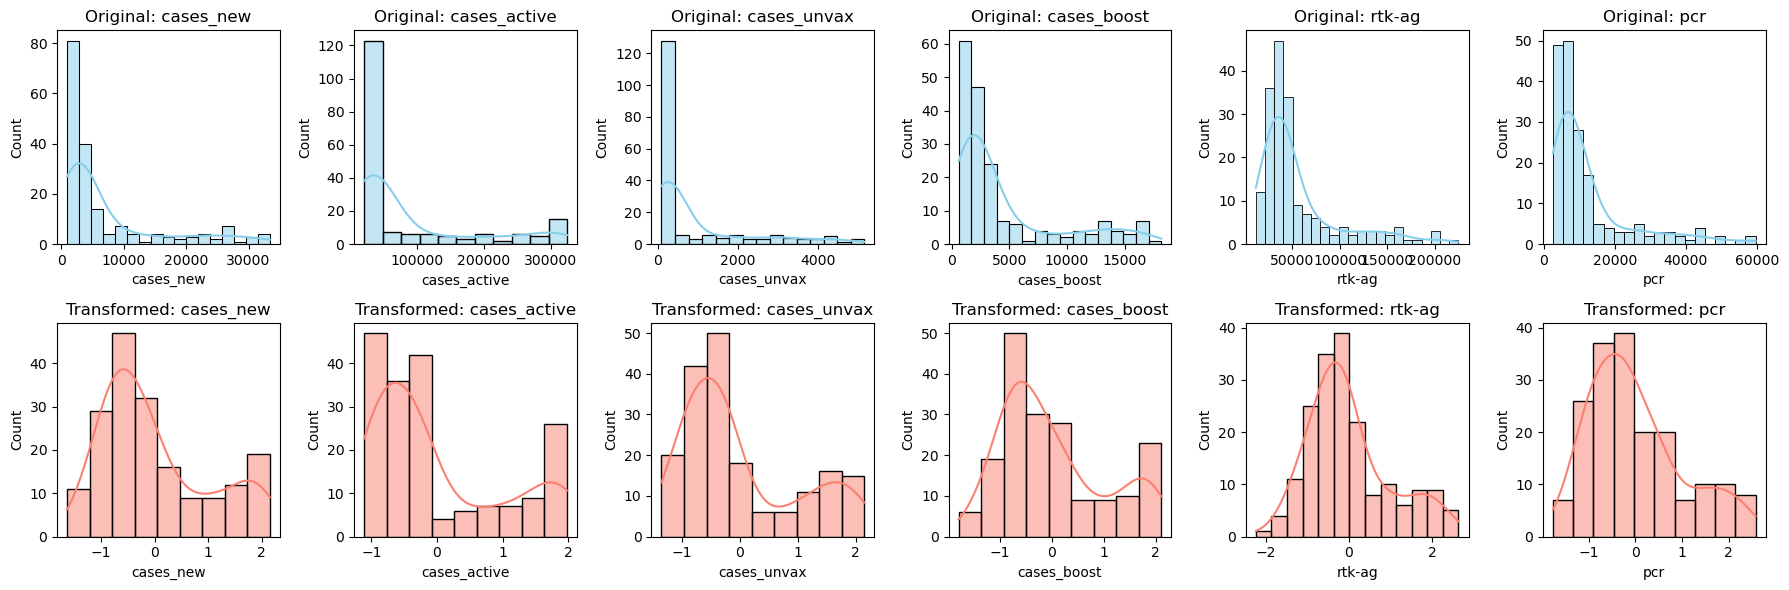

In [170]:
# --- Feature Visualization ---

# Original features before selection
original_features = df.drop(columns=['date'], errors="ignore")  # no classification target now

# Features after selection and transformations (Part 2.1 & 2.2)
processed_features = X.copy()

# Plot distributions before and after feature engineering
num_features_to_plot = min(6, len(processed_features.columns))  # plot a few examples
sample_cols = processed_features.columns[:num_features_to_plot]

plt.figure(figsize=(18, 6))

for i, col in enumerate(sample_cols, 1):
    # Original distribution
    plt.subplot(2, num_features_to_plot, i)
    sns.histplot(original_features[col], kde=True, color='skyblue')
    plt.title(f'Original: {col}')
    
    # Transformed distribution
    plt.subplot(2, num_features_to_plot, i + num_features_to_plot)
    sns.histplot(processed_features[col], kde=True, color='salmon')
    plt.title(f'Transformed: {col}')

plt.tight_layout()
plt.show()


### Part 2.4: Feature Creation (Lagging)

**Objective:** Create lag features from the past 8–14 days to predict **next week's Covid-19 cases**.

**Reasoning:**  
1. Using data from 8–14 days prior captures **recent trends** without using future data (prevents look-ahead bias).  
2. Shifting the target 7 days forward aligns with **next week’s prediction**.  
3. Lagged features help models like KNN, Linear Regression, and Decision Trees capture temporal patterns in the data.


In [171]:
# --- Create lagged features ---
lag_data = {}
start_lag = 8
end_lag = 14

for col in X.columns:
    for lag in range(start_lag, end_lag + 1):
        lag_data[f"{col}_lag{lag}"] = X[col].shift(lag)

# Convert to DataFrame
lagged_features = pd.DataFrame(lag_data)
lagged_features["date"] = df["date"]

# Shift target (cases_new) backward by 7 days to represent next week's cases
y = df["cases_new"].shift(-7)

# Combine lagged features with target
df_weekly = pd.concat([lagged_features, y.rename("cases_next_week")], axis=1)

# Drop rows with NaNs created by shifting
df_weekly = df_weekly.dropna().reset_index(drop=True)

# Final dataset for modeling
X_final = df_weekly.drop(columns=["date", "cases_next_week"])
y_final = df_weekly["cases_next_week"]

print("Feature matrix shape:", X_final.shape)
print("Target vector shape:", y_final.shape)


Feature matrix shape: (163, 280)
Target vector shape: (163,)


## Part 3: Splitting the Dataset

**Objective:**  
Split the processed dataset into **training**, **validation**, and **testing sets** for model training, hyperparameter tuning, and final evaluation.

**Reasoning:**  
1. The data is **time-series** (daily Covid-19 cases with lag features), so **random shuffling is avoided** to prevent data leakage.  
2. We use a **chronological split**:  
   1. **Training set:** First 60% → used to learn patterns.  
   2. **Validation set:** Next 20% → used to tune hyperparameters of Linear Regression, KNN, and Decision Tree Regression.  
   3. **Testing set:** Final 20% → held-out set for evaluating model performance on unseen data.  
3. This approach ensures **generalization** and simulates real-world forecasting, where predictions are always based on **past data**.


Train shape: (97, 280) (97,)
Validation shape: (32, 280) (32,)
Test shape: (34, 280) (34,)


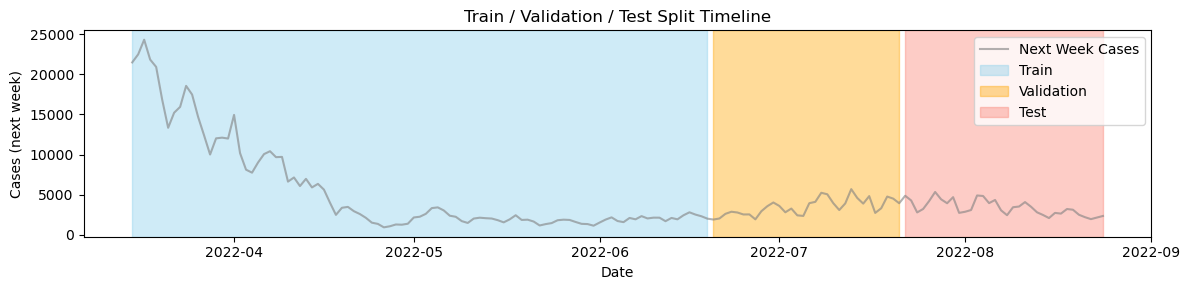

In [172]:
# Keep the date column for plotting
dates = df_weekly["date"]

# Chronological split
n = len(X_final)
train_size = int(0.6 * n)
val_size = int(0.2 * n)

# Training set (first 60%)
X_train = X_final.iloc[:train_size]
y_train = y_final.iloc[:train_size]
dates_train = dates.iloc[:train_size]

# Validation set (next 20%)
X_val = X_final.iloc[train_size:train_size + val_size]
y_val = y_final.iloc[train_size:train_size + val_size]
dates_val = dates.iloc[train_size:train_size + val_size]

# Testing set (final 20%)
X_test = X_final.iloc[train_size + val_size:]
y_test = y_final.iloc[train_size + val_size:]
dates_test = dates.iloc[train_size + val_size:]

print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

# Visualization of splits
plt.figure(figsize=(12, 3))
plt.plot(dates, y_final, label="Next Week Cases", color="gray", alpha=0.6)

plt.axvspan(dates_train.min(), dates_train.max(), color="skyblue", alpha=0.4, label="Train")
plt.axvspan(dates_val.min(), dates_val.max(), color="orange", alpha=0.4, label="Validation")
plt.axvspan(dates_test.min(), dates_test.max(), color="salmon", alpha=0.4, label="Test")

plt.title("Train / Validation / Test Split Timeline")
plt.xlabel("Date")
plt.ylabel("Cases (next week)")
plt.legend()
plt.tight_layout()
plt.show()


## Part 5: Model Training

**Training Process:**  
- Train the model on the **training set** (March–May 2021).  
- Use the **validation set** (June 2021) for hyperparameter tuning.  
- Final model will later be tested on the **test set** (July–August 2021).  
- Track time taken to train the model

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

import time

def train(model, X_train, y_train):
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()

    train_time = end_time - start_time

    return train_time

training_times = {
    "knn": 0.0,
    "log_reg": 0.0,
    "dt": 0.0
}

### Part 5.1 K-Nearest Neighbors (KNN)  

**Objective:**  
Train a **K-Nearest Neighbors (KNN)** classifier to predict the binary Covid-19 risk level (`high` vs `low`) for the following week.  

**Why KNN?**  
- Simple and intuitive method for classification.  
- Makes no strong assumptions about the data distribution.  
- Effective when decision boundaries are nonlinear.  
- Useful as a baseline model for comparison.  

**Hyperparameters to Tune:**  
1. `n_neighbors` → Number of neighbors considered for classification (controls smoothness vs flexibility).  
2. `weights` → Voting scheme (`uniform` vs `distance`).  
3. `metric` → Distance measure (`euclidean`, `manhattan`, `minkowski`).  

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# --- KNN with GridSearchCV ---
knn = KNeighborsClassifier()

knn_params = {
    "n_neighbors": [3, 5, 7, 9, 11, 15],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan", "minkowski"],
}

grid_knn = GridSearchCV(
    estimator=knn,
    param_grid=knn_params,
    scoring="f1",  # balance between precision and recall
    cv=3,
    n_jobs=-1,
    verbose=1,
)

training_times["knn"] = train(grid_knn, X_train, y_train)

print("Best KNN Parameters:", grid_knn.best_params_)
print("Best Training CV Score (F1):", grid_knn.best_score_)

# Evaluate on validation set
y_val_pred_knn = grid_knn.best_estimator_.predict(X_val)
f1_val_knn = f1_score(y_val, y_val_pred_knn)
print("Validation F1 Score (KNN):", f1_val_knn)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best KNN Parameters: {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'uniform'}
Best Training CV Score (F1): 0.9563492063492062
Validation F1 Score (KNN): 0.0


### Part 5.2 Logistic Regression  

**Objective:**  
Train a **Logistic Regression** classifier to predict the binary Covid-19 risk level (`high` vs `low`) for the following week.  

**Why Logistic Regression?**  
- Well-suited for **binary classification tasks**.  
- Provides **probabilistic outputs**, which can be thresholded for flexible decision-making.  
- Easy to interpret (coefficients show feature importance).  
- Efficient and fast to train.  

**Hyperparameters to Tune:**  
1. `penalty` → Type of regularization (`l1`, `l2`, `elasticnet`, or `none`)  
2. `solver` → Optimization algorithm (`liblinear`, `lbfgs`, `saga`)  
3. `max_iter` → Maximum number of iterations (ensures convergence)  

In [ ]:
from sklearn.linear_model import LogisticRegression

# --- Logistic Regression with GridSearchCV (valid parameter grid only) ---
log_reg_params = [
    {
        "penalty": ["l2"],
        "C": [0.01, 0.1, 1, 10],
        "solver": ["lbfgs", "liblinear"],
        "max_iter": [500, 1000],
    },
    {
        "penalty": ["l1"],
        "C": [0.01, 0.1, 1, 10],
        "solver": ["liblinear", "saga"],
        "max_iter": [500, 1000],
    },
    {
        "penalty": ["elasticnet"],
        "C": [0.01, 0.1, 1, 10],
        "solver": ["saga"],
        "l1_ratio": [0.3, 0.5, 0.7],
        "max_iter": [500, 1000],
    },
    {"penalty": [None], "solver": ["lbfgs"], "C": [1], "max_iter": [500, 1000]},
]

log_reg = LogisticRegression()

grid_log_reg = GridSearchCV(
    log_reg, log_reg_params, cv=3, scoring="f1", n_jobs=-1, verbose=1
)

training_times["log_reg"] = train(grid_log_reg, X_train, y_train)

print("Best Logistic Regression Parameters:", grid_log_reg.best_params_)
print("Best Training CV Score (F1):", grid_log_reg.best_score_)

# Evaluate on validation set
y_val_pred_log = grid_log_reg.best_estimator_.predict(X_val)
f1_val_log = f1_score(y_val, y_val_pred_log)
print("Validation F1 Score (Logistic Regression):", f1_val_log)

Fitting 3 folds for each of 58 candidates, totalling 174 fits
Best Logistic Regression Parameters: {'C': 0.1, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
Best Training CV Score (F1): 0.9237788513150832
Validation F1 Score (Logistic Regression): 0.0


### Part 5.3 Decision Tree  

**Objective:**  
Train a **Decision Tree** classifier to predict the binary Covid-19 risk level (`high` vs `low`) for the following week.  

**Why Decision Tree?**  
- Provides clear, interpretable **if-then rules**.  
- Handles continuous features (lagged values) without requiring scaling.  
- Simple to train and tune, making it beginner-friendly.  

**Hyperparameters to Tune:**  
1. `max_depth` → Maximum depth of the tree (controls overfitting).  
2. `min_samples_split` → Minimum samples required to split a node.  
3. `min_samples_leaf` → Minimum samples required at a leaf node.  
4. `max_features` → Number of features to consider when splitting.  

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# --- Decision Tree with GridSearchCV ---
dt_params = {
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "max_features": [None, "sqrt", "log2"],
}

dt_clf = DecisionTreeClassifier()

grid_dt = GridSearchCV(
    dt_clf, dt_params, cv=3, scoring="f1", n_jobs=-1, verbose=1
)

training_times["dt"] = train(grid_dt, X_train, y_train)

print("Best Decision Tree Parameters:", grid_dt.best_params_)
print("Best Training CV Score (F1):", grid_dt.best_score_)

# Evaluate on validation set
y_val_pred_dt = grid_dt.best_estimator_.predict(X_val)
f1_val_dt = f1_score(y_val, y_val_pred_dt)
print("Validation F1 Score (Decision Tree):", f1_val_dt)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Decision Tree Parameters: {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best Training CV Score (F1): 1.0
Validation F1 Score (Decision Tree): 0.0


## Part 6: Plotting & Evaluation  

**Objective:**  
Evaluate the trained models (**Logistic Regression, KNN, Decision Tree**) on the **test set (July–August 2021)** and compare their performance using multiple evaluation metrics and visualization techniques.  

### 6.1 Evaluation Metrics  

Each model will be assessed on the following classification metrics:  
1. **Accuracy** – overall proportion of correct predictions.  
2. **Recall (Sensitivity)** – ability to correctly identify *high-risk weeks*.  
3. **Precision** – proportion of predicted *high-risk weeks* that were correct.  
4. **Specificity** – ability to correctly identify *low-risk weeks*.  
5. **F1 Score** – harmonic mean of precision and recall (balances false positives/negatives).  
6. **Area Under the Curve (AUC)** – discriminatory power of the classifier.  
7. **Training Speed** – time taken to train each model.  

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
)
import pandas as pd
import numpy as np
import warnings

# Ignore warnings for undefined metrics (e.g., AUC when only one class is present)
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Dictionary of best trained models
best_models = {
    "knn": grid_knn.best_estimator_,
    "log_reg": grid_log_reg.best_estimator_,
    "dt": grid_dt.best_estimator_,
}

# Initialize evaluation results
eval_results = {
    "Model": [],
    "Accuracy": [],
    "Recall": [],
    "Precision": [],
    "Specificity": [],
    "F1 Score": [],
    "AUC": [],
    "Training Time (s)": [],
}

# Evaluate each model
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    # Use probabilities if available, else None
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan

    # AUC computation: only if both classes are present
    if y_prob is not None and len(np.unique(y_test)) == 2:
        auc_score = roc_auc_score(y_test, y_prob)
    else:
        auc_score = np.nan

    eval_results["Model"].append(name)
    eval_results["Accuracy"].append(accuracy_score(y_test, y_pred))
    eval_results["Recall"].append(recall_score(y_test, y_pred))
    eval_results["Precision"].append(precision_score(y_test, y_pred))
    eval_results["Specificity"].append(specificity)
    eval_results["F1 Score"].append(f1_score(y_test, y_pred))
    eval_results["AUC"].append(auc_score)
    eval_results["Training Time (s)"].append(training_times.get(name.lower().replace(" ", "_"), np.nan))

# Convert to DataFrame for display
eval_df = pd.DataFrame(eval_results)
display(eval_df)


,Model,Accuracy,Recall,Precision,Specificity,F1 Score,AUC,Training Time (s)
0,knn,0.970588,0.0,0.0,1.0,0.0,0.500000,1.112093
1,log_reg,0.970588,0.0,0.0,1.0,0.0,0.348485,3.067699
2,dt,0.970588,0.0,0.0,1.0,0.0,0.500000,2.644991


### 6.2 Visualization Plan  

Plots will be used to support both **individual model performance** and **comparative analysis**:  

- **Confusion Matrix** (per model) → Show true positives, true negatives, false positives, false negatives.  
- **ROC Curve** → True Positive Rate vs False Positive Rate, with AUC values.  
- **Precision-Recall Curve** → Highlights trade-off between precision and recall, useful in imbalanced datasets.  
- **Overfitting/Underfitting Curves** → Compare training vs validation F1 scores across hyperparameters (to check if a model generalizes well).  
- **Comparison Bar Plot** → Summarize Accuracy, Recall, Precision, F1, AUC across all three models in one chart for easy interpretation. 

### 6.3 Decision Criteria  

- The **best model** will not be selected by accuracy alone, but by considering **F1 Score and Recall** as primary metrics.  
  - This ensures the model prioritizes correctly identifying *high-risk weeks*, which is critical in public health settings.  
- **Interpretability** will also be considered:  
  - Logistic Regression provides coefficients (easy to explain).  
  - KNN is intuitive but harder to interpret feature importance.  
  - Decision Trees allow visualization of splits for decision rules.  
